In [2]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import Dataset, DataLoader
import json
from pathlib import Path
from transformer_lens.hook_points import HookPoint
from transformers import AutoTokenizer, AutoModelForCausalLM, PaliGemmaForConditionalGeneration
from sklearn.model_selection import train_test_split
import pandas as pd
import gc
import os
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

# from random import random
import random
def seed_everywhere(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    random.seed(seed)    
SEED = 42
MAX_SEQ_LEN = 64 # location to truncate our inputs
DEVICE_1 = 'cuda:1'
DEVICE_2 = 'cuda:2' # the second GPU
NUM_CLASSES = 0
seed_everywhere(SEED)


/opt/conda/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/opt/conda/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was prov

# exp

In [3]:
class ActivationDataset(Dataset):
    """Dataset for model activations with labels"""
    def __init__(self, activations, labels):
        self.activations = torch.tensor(activations, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.activations)
    
    def __getitem__(self, idx):
        return self.activations[idx], self.labels[idx]

class LinearProbe(nn.Module):
    """Simple linear probe for classification"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        return self.linear(x)

class LinearProbingExperiment:
    def __init__(self, model_name="gemma", concept="animals"):
        self.model_name = model_name
        self.concept = concept
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     def load_activations(self, file_path):
#         """Load activations from file (assuming numpy format)"""
#         data = np.load(file_path, allow_pickle=True)
#         return data['activations'], data['labels']
    
#     def create_cat_dog_labels(self, texts):
#         """Simple cat/dog labeler based on keywords"""
#         labels = []
#         for text in texts:
#             text_lower = text.lower()
#             if any(word in text_lower for word in ['cat', 'feline', 'kitten', 'meow']):
#                 labels.append(0)  # cat
#             elif any(word in text_lower for word in ['dog', 'canine', 'puppy', 'bark', 'woof']):
#                 labels.append(1)  # dog
#             else:
#                 labels.append(-1)  # neither/unknown
#         return np.array(labels)
    
#     def extract_gemma_activations(self, model, tokenizer, texts, layer_idx=-1):
#         """Extract activations from Gemma model at specified layer"""
#         activations = []
        
#         with torch.no_grad():
#             for text in texts:
#                 inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
#                 inputs = {k: v.to(self.device) for k, v in inputs.items()}
                
#                 # Forward pass with output_hidden_states=True
#                 outputs = model(**inputs, output_hidden_states=True)
#                 hidden_states = outputs.hidden_states[layer_idx]  # Get specified layer
                
#                 # Use mean pooling across sequence length
#                 activation = hidden_states.mean(dim=1).cpu().numpy()
#                 activations.append(activation[0])
        
#         return np.array(activations)
    
    def train_sklearn_probe(self,
                             X_train: np.ndarray,
                             y_train: np.ndarray,
                             X_test: np.ndarray,
                             y_test: np.ndarray,
                             texts_test: list = None) -> tuple:
        """
        Train a sklearn logistic regression probe on flattened activations,
        and return the trained probe and a results dict including misclassified samples:
        - train_acc, test_acc, classification_report
        - y_test, y_pred
        - misclassified: list of dicts with index, text, true_label, pred_label
        """
        # Set random state for reproducibility
        probe = LogisticRegression(max_iter=1000, random_state=SEED)

        # Flatten sequence and hidden dimensions
        n_train_samples = X_train.shape[0]
        n_test_samples = X_test.shape[0]
        X_train_flat = X_train.reshape(n_train_samples, -1)
        X_test_flat = X_test.reshape(n_test_samples, -1)
        print(f"X_train_flat shape: {X_train_flat.shape}")
        print(f"y_train shape: {len(y_train)}")
        print(f"X_test_flat shape: {X_test_flat.shape}")
        print(f"y_test shape: {len(y_test)}")

        # Fit probe
        probe.fit(X_train_flat, y_train)

        # Predict
        train_pred = probe.predict(X_train_flat)
        test_pred = probe.predict(X_test_flat)

        # Compute metrics
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        report = classification_report(y_test, test_pred)

        # Build results dict
        results = {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'classification_report': report,
            'y_test': y_test.tolist() if hasattr(y_test, 'tolist') else list(y_test),
            'y_pred': test_pred.tolist(),
        }

        # Collect misclassified samples
        misclassified = []
        if texts_test is not None:
            for idx, (true_label, pred_label) in enumerate(zip(y_test, test_pred)):
                if true_label != pred_label:
                    misclassified.append({
                        'index': idx,
                        'text': texts_test[idx],
                        'true_label': int(true_label),
                        'pred_label': int(pred_label)
                    })
        results['misclassified'] = misclassified

        return probe, results
    
    def train_torch_probe(self, X_train, y_train, X_test, y_test, epochs=100):
        """Train PyTorch linear probe"""
        input_dim = X_train.shape[0] # is this "how many text snppets"?
#         num_classes = len(np.unique(y_train)) 
        num_classes = NUM_CLASSES # let's do binary classifier
    # TODO: let's imitate sigmoid
        train_dataset = ActivationDataset(X_train, y_train)
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
        probe = LinearProbe(input_dim, num_classes).to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(probe.parameters(), lr=0.001)
        
        # Training loop
        for epoch in range(epochs):
            probe.train()
            total_loss = 0
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = probe(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss/len(train_loader):.4f}")
        
        # Evaluation
        probe.eval()
        with torch.no_grad():
            X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(self.device)
            test_outputs = probe(X_test_tensor)
            test_pred = torch.argmax(test_outputs, dim=1).cpu().numpy()
            
            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(self.device)
            train_outputs = probe(X_train_tensor)
            train_pred = torch.argmax(train_outputs, dim=1).cpu().numpy()
        
        results = {
            'train_acc': accuracy_score(y_train, train_pred),
            'test_acc': accuracy_score(y_test, test_pred),
            'classification_report': classification_report(y_test, test_pred)
        }
        
        return probe, results
    
    def run_experiment(self, gemma_activations, gemma_labels, 
                      polygemma_activations, polygemma_labels):
        """Run complete probing experiment"""
        print(f"Running linear probing experiment: {self.concept}")
        print(f"Gemma training data: {gemma_activations.shape}")
        print(f"PolyGemma test data: {polygemma_activations.shape}")
        
        # Train on Gemma, test on PolyGemma
        results = {}
    
        
        # sklearn probe
        print("\n--- Training sklearn probe ---")
        # Do the split!
        gemma_activations_train, _, gemma_labels_train, _  = train_test_split(gemma_activations, gemma_labels, test_size=0.2, random_state=SEED)
        _, polygemma_activations_test, _, polygemma_labels_test = train_test_split(polygemma_activations, polygemma_labels, test_size=0.2, random_state=SEED)
        print(f"size of gemma_activations_train: {gemma_activations_train.shape}, size of gemma_labels_train: {len(gemma_labels_train)}")
        print(f"size of polygemma_activations_test: {polygemma_activations_test.shape}, size of polygemma_labels_test: {len(polygemma_labels_test)}")
        sklearn_probe, sklearn_results = self.train_sklearn_probe(
            gemma_activations_train.cpu(), gemma_labels_train, # train
            polygemma_activations_test.cpu(), polygemma_labels_test # test
        )
        results['sklearn'] = sklearn_results
        
#         # PyTorch probe
#         print("\n--- Training PyTorch probe ---")
#         torch_probe, torch_results = self.train_torch_probe(
#             gemma_activations, gemma_labels, # train
#             polygemma_activations, polygemma_labels # test
#         )
#         results['torch'] = torch_results
        
        return results
    
    def save_results(self, results, output_path):
        """Save experiment results"""
        output_path = Path(output_path)
        output_path.parent.mkdir(parents=True, exist_ok=True)
        
        # Convert numpy types to Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        json_results = json.loads(json.dumps(results, default=convert_numpy))
        
        with open(output_path, 'w') as f:
            json.dump(json_results, f, indent=2)



# synth data

In [4]:
# # Synthetic text data for cat/dog classification
# text = [
#     # Cat examples (label 0)
#     "The fluffy cat purred softly on the windowsill, watching birds outside.",
#     "My kitten loves to chase the red laser pointer around the living room.",
#     "The orange tabby cat stretched lazily in the warm afternoon sunlight.",
#     "She adopted a rescue cat from the local animal shelter last week.",
#     "The cat's whiskers twitched as it stalked the toy mouse across the floor.",
#     "Fluffy meowed loudly when her food bowl was empty this morning.",
#     "The black cat gracefully jumped onto the kitchen counter with ease.",
#     "My feline friend enjoys napping in cardboard boxes all day long.",
#     "The cat's green eyes glowed mysteriously in the dim moonlight tonight.",
#     "Her pet cat brings dead mice to the doorstep every morning.",
#     "The Siamese cat has the most beautiful blue eyes I've ever seen.",
#     "Tom cat climbed up the tall oak tree to escape the neighborhood dogs.",
#     "The veterinarian said the kitten needs its vaccinations next month.",
#     "My cat purrs so loudly it sounds like a tiny motor running.",
#     "The calico cat had three adorable kittens in the barn yesterday.",
#     "She trained her cat to use the toilet instead of a litter box.",
#     "The Persian cat's long fur requires daily brushing to prevent matting.",
#     "My indoor cat watches wildlife documentaries on TV with great interest.",
#     "The stray cat finally trusted me enough to eat from my hand.",
#     "Her cat knocked over the expensive vase while chasing a butterfly.",
    
#     # Dog examples (label 1)
#     "The golden retriever barked excitedly when his owner came home today.",
#     "My dog loves to fetch tennis balls in the backyard every afternoon.",
#     "The small puppy wagged its tail when meeting new people yesterday.",
#     "She takes her German shepherd for long walks in the park.",
#     "The dog's tail wagged furiously when it saw the treat jar.",
#     "Max barked at the mailman who comes by every morning.",
#     "The border collie herded the sheep expertly across the green field.",
#     "My canine companion loves swimming in the lake during hot summers.",
#     "The dog trainer taught the puppy basic commands like sit and stay.",
#     "Her loyal dog waited patiently outside the grocery store for her.",
#     "The beagle's nose led it straight to the hidden treats upstairs.",
#     "My dog howls along with the sirens from passing fire trucks.",
#     "The veterinarian recommended a special diet for the overweight bulldog.",
#     "The rescue dog was nervous but gradually warmed up to us.",
#     "My puppy chewed up my favorite pair of running shoes yesterday.",
#     "The dog park was crowded with excited pups playing together today.",
#     "Her service dog helps her navigate safely through busy city streets.",
#     "The hunting dog pointed steadily at the birds hiding in bushes.",
#     "My dog greets every visitor with enthusiastic tail wagging and jumping.",
#     "The old dog slept peacefully by the fireplace on cold nights.",
    
#     # Neutral/other examples (label 2) - neither cats nor dogs
#     "The morning sun cast beautiful shadows across the empty parking lot.",
#     "She enjoyed reading mystery novels while drinking her evening tea.",
#     "The mathematics professor explained complex equations on the whiteboard clearly.",
#     "Fresh vegetables from the farmers market made an excellent dinner tonight.",
#     "The old library contained thousands of books on various subjects.",
#     "He repaired the broken bicycle tire using tools from the garage.",
#     "The weather forecast predicted rain for the entire weekend ahead.",
#     "Students gathered in the cafeteria to discuss their upcoming project.",
#     "The concert featured amazing performances by local musicians and bands.",
#     "She planted colorful flowers in her garden beds this spring.",
#     "The computer program crashed unexpectedly during the important presentation today.",
#     "Ocean waves crashed against the rocky cliffs during the storm.",
#     "The chef prepared an elaborate feast for the wedding celebration.",
#     "Mountains covered in snow looked majestic against the clear sky.",
#     "The museum displayed artifacts from ancient civilizations throughout history.",
#     "Traffic was heavy on the highway during rush hour yesterday.",
#     "The smartphone battery died right before the important phone call.",
#     "Autumn leaves fell gently from the trees in vibrant colors.",
#     "The construction workers finished building the new bridge ahead of schedule.",
#     "She studied diligently for her final exams in the quiet library."
# ]

# # Corresponding labels: 0=cat, 1=dog, 2=neutral
# labels = [
#     # Cat labels (0)
#     0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#     # Dog labels (1) 
#     1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#     # Neutral labels (2)
#     2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
# ]

# # Verify data consistency
# print(f"Total texts: {len(text)}")
# print(f"Total labels: {len(labels)}")
# print(f"Cat examples: {labels.count(0)}")
# print(f"Dog examples: {labels.count(1)}")
# print(f"Neutral examples: {labels.count(2)}")

# COCO annotations

In [5]:
SAVE_DIR = '../data'
cat_df = pd.read_csv(f'{SAVE_DIR}/coco_cat_binary_with_captions_balanced.csv').sample(1000, random_state = SEED)
dog_df = pd.read_csv(f'{SAVE_DIR}/coco_dog_binary_with_captions_balanced.csv').sample(1000, random_state = SEED)

cat_df.captions = cat_df.captions.apply(lambda x:eval(x)[0])
dog_df.captions = dog_df.captions.apply(lambda x:eval(x)[0])

In [6]:
cat_df.captions.map(len)

2378    41
2420    45
1940    48
1592    60
2283    56
        ..
259     57
1001    67
3265    53
1912    39
3074    46
Name: captions, Length: 1000, dtype: int64

In [7]:
cat_texts, cat_labels = cat_df.captions.tolist(), cat_df.label.tolist()
print(f"length of cat_texts: {len(cat_texts)}, length of cat_labels: {len(cat_labels)}")
dog_texts, dog_labels = dog_df.captions.tolist(), dog_df.label.tolist()

length of cat_texts: 1000, length of cat_labels: 1000


# load model & get act

In [8]:
def load_models_with_eval(model_name, device="cuda"):
    if "paligemma" in model_name.lower():
        from transformers import PaliGemmaForConditionalGeneration
        model = PaliGemmaForConditionalGeneration.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,  # Use fp16 for memory efficiency
            device_map=None  # We'll handle device placement manually
        )
        model = model.to(device)
        language_model = model.language_model
    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_name, 
            trust_remote_code=True,
            torch_dtype=torch.float32,
            device_map=None
        )
        model = model.to(device)
        language_model = model
            
    language_model.eval()
    return language_model

def get_inputs_from_text(model_name, text, device):
    tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # FIXED: More robust tokenization with proper padding token handling
    # Ensure we have a pad token

    # Tokenize with safer parameters
    inputs = tokenizer(
        text, 
        return_tensors="pt", 
        padding="max_length",
        truncation=True,
        max_length=MAX_SEQ_LEN,
        add_special_tokens=True  # Ensure special tokens are added properly
    )

    # FIXED: Validate token IDs are within vocabulary range
    vocab_size = tokenizer.vocab_size
    input_ids = inputs['input_ids']

    # Check for out-of-bounds token IDs
    if torch.any(input_ids >= vocab_size) or torch.any(input_ids < 0):
        print(f"⚠️  Invalid token IDs detected. Max ID: {input_ids.max()}, Vocab size: {vocab_size}")
        # Clamp invalid IDs to valid range
        input_ids = torch.clamp(input_ids, 0, vocab_size - 1)
        inputs['input_ids'] = input_ids

    inputs = {k: v.to(device) for k, v in inputs.items()}
    return inputs
    
def get_acts(language_model, text, layer, model_name, device):
    inputs = get_inputs_from_text(model_name, text, device)
    if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
        if layer < len(language_model.model.layers):
            target_layer = language_model.model.layers[layer]
        else:
            print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
            return torch.randn(1, 64, 2304).to(DEVICE), 0.0
    activations = None


    def activation_hook(module, inputs, output):
        nonlocal activations
        try:
            if isinstance(output, tuple):
                activations = output[0].clone().detach()
            else:
                activations = output.clone().detach()
        except Exception as e:
            print(f"⚠️  Error in activation hook: {e}")

    # FIXED: More robust layer identification
    target_layer = None
    try:
        if hasattr(language_model, 'model') and hasattr(language_model.model, 'layers'):
            if layer < len(language_model.model.layers):
                target_layer = language_model.model.layers[layer]
            else:
                print(f"❌ Layer {layer} out of range. Model has {len(language_model.model.layers)} layers")
                return torch.randn(1, 64, 2304).to(DEVICE), 0.0
        elif hasattr(language_model, 'layers'):
            if layer < len(language_model.layers):
                target_layer = language_model.layers[layer]
            else:
                print(f"❌ Layer {layer} out of range. Model has {len(language_model.layers)} layers")
                return torch.randn(1, 64, 2304).to(DEVICE), 0.0
        else:
            print(f"❌ Could not find layers in model structure")
            return torch.randn(1, 64, 2304).to(DEVICE), 0.0
    except Exception as e:
        print(f"❌ Error accessing layer {layer}: {e}")
        return torch.randn(1, 64, 2304).to(DEVICE), 0.0

    if target_layer is None:
        print(f"❌ Could not find layer {layer}")
        return torch.randn(1, 64, 2304).to(DEVICE), 0.0

    hook = target_layer.register_forward_hook(activation_hook)

    # Forward pass to get activations
    with torch.no_grad():
        try:
            if "paligemma" in model_name.lower():
                _ = language_model(**inputs)
            else:
                _ = language_model(**inputs)
        except Exception as e:
            print(f"⚠️  Error in activation extraction: {e}")

    hook.remove()
    if activations is None:
        print(f"⚠️  Failed to extract activations from layer {layer}")
        # FIXED: Return appropriate tensor size based on model
        try:
            # Try to get the actual hidden size from the model config
            if hasattr(language_model, 'config') and hasattr(language_model.config, 'hidden_size'):
                hidden_size = language_model.config.hidden_size
            else:
                hidden_size = 2304  # fallback
            activations = torch.randn(1, 64, hidden_size).to(DEVICE)
        except:
            activations = torch.randn(1, 64, 2304).to(DEVICE)

    return activations

In [9]:
# Initialize experiment
experiment = LinearProbingExperiment(concept="cat_dog_classification")


# Exp1: Gemma-Paligemma

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 15.41 GiB is free. Process 2268115 has 28.97 GiB memory in use. Of the allocated memory 23.62 GiB is allocated by PyTorch, and 4.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 80

X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 5 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.6550
Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       105
           1       1.00      0.27      0.43        95

    accuracy                           0.66       200
   macro avg       0.80      0.64      0.59       200
weighted avg       0.79      0.66      0.60       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 15.41 GiB is free. Process 2268115 has 28.97 GiB memory in use. Of the allocated memory 23.62 GiB is allocated by PyTorch, and 4.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See document

Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 11 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.5700
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.99      0.71       105
           1       0.91      0.11      0.19        95

    accuracy                           0.57       200
   macro avg       0.73      0.55      0.45       200
weighted avg       0.72      0.57      0.46       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to al

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



=== LAYER 13 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.5250
Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       105
           1       0.00      0.00      0.00        95

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 15.41 GiB is free. Process 2268115 has 28.97 GiB memory in use. Of the allocated memory 23.62 GiB is allocated by PyTorch, and 4.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing exp

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



=== LAYER 14 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.5250
Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       105
           1       0.00      0.00      0.00        95

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 17.61 GiB is free. Process 2268115 has 26.78 GiB memory in use. Of the allocated memory 23.62 GiB is allocated by PyTorch, and 2.14 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing exp

/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/py311/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



=== LAYER 15 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.5250
Classification Report:
              precision    recall  f1-score   support

           0       0.53      1.00      0.69       105
           1       0.00      0.00      0.00        95

    accuracy                           0.53       200
   macro avg       0.26      0.50      0.34       200
weighted avg       0.28      0.53      0.36       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 15.41 GiB is free. Process 2268115 has 28.97 GiB memory in use. Of the allocated memory 23.62 GiB is allocated by PyTorch, and 4.34 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing exp

Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 21 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.8900
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       105
           1       0.96      0.80      0.87        95

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.89      0.89       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to al

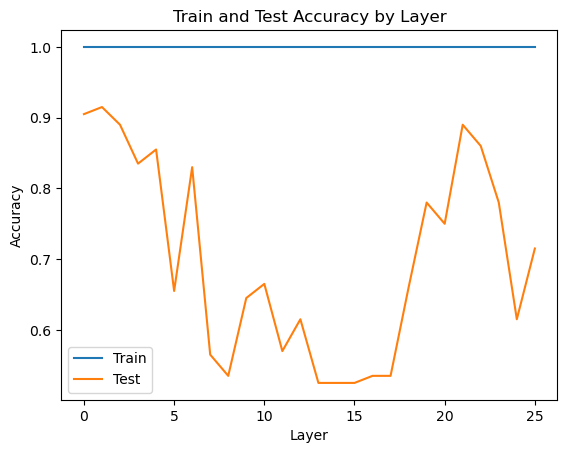

In [8]:


# load models
model1_name = "google/gemma-2-2b"  # Base Gemma-2-2B (LLM)
model2_name = "google/paligemma2-3b-pt-224"

gemma = load_models_with_eval(model1_name, DEVICE_1)
paligemma = load_models_with_eval(model2_name, DEVICE_2)

# # Dummy activations (replace with real data)
# gemma_activations = np.random.randn(1000, 768)  # 1000 samples, 768 dims
# gemma_labels = np.random.randint(0, 2, 1000)    # binary cat/dog labels

# polygemma_activations = np.random.randn(200, 768)  # 200 test samples
# polygemma_labels = np.random.randint(0, 2, 200)

layer_to_test = list(range(26))
all_results = []
# Run experiment per layer
for layer in layer_to_test:
    # Produce activation-label pairs
    with torch.inference_mode():
        gemma_activations = get_acts(gemma, cat_texts, layer, model1_name, DEVICE_1)
        polygemma_activations = get_acts(paligemma, cat_texts, layer, model2_name, DEVICE_2)

    # === Run probe experiment ===
    results = experiment.run_experiment(
        gemma_activations, cat_labels,
        polygemma_activations, cat_labels
    )
    all_results.append(results)

    print(f"\n=== LAYER {layer} RESULTS ===")
    print(f"Train Accuracy: {results['sklearn']['train_acc']:.4f}")
    print(f"Test Accuracy: {results['sklearn']['test_acc']:.4f}")
    print("Classification Report:")
    print(results['sklearn']['classification_report'])

    # Save results
    experiment.save_results(results, f"../output/linear_probing_results_{layer}.json")

    # Save misclassified examples
    if 'y_test' in results['sklearn'] and 'y_pred' in results['sklearn']:
        mis_indices = [i for i, (yt, yp) in enumerate(zip(
            results['sklearn']['y_test'], results['sklearn']['y_pred']
        )) if yt != yp]
        mis_info = [
            {
                'text': cat_texts[i],  # assuming you meant cat_texts not text
                'true_label': int(results['sklearn']['y_test'][i]),
                'pred_label': int(results['sklearn']['y_pred'][i])
            }
            for i in mis_indices
        ]
        with open(f"../output/misclassified_layer_{layer}.json", 'w') as f:
            json.dump(mis_info, f, indent=2)
    else:
        print("Warning: 'y_test' or 'y_pred' not found in results; misclassifications not saved.")
          
    del gemma_activations, polygemma_activations, results
    gc.collect()
    torch.cuda.empty_cache()
          
# ===== Plot Train and Test Accuracy Across Layers =====
import matplotlib.pyplot as plt

layers = layer_to_test
train_accs = [res['sklearn']['train_acc'] for res in all_results]
test_accs = [res['sklearn']['test_acc'] for res in all_results]

plt.figure()
plt.plot(layers, train_accs)
plt.plot(layers, test_accs)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Layer')
plt.legend(['Train', 'Test'])
plt.savefig("../figs_tabs/Linear Probe Train and Test Accuracy by Layer.png")
plt.show()


# Exp2: Gemma-Gemma

Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00, 65.71it/s]


⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 16.48 GiB is free. Process 1454354 has 27.90 GiB memory in use. Of the allocated memory 24.09 GiB is allocated by PyTorch, and 2.79 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 2 has a total capacity of 44.38 GiB of which 16.48 GiB is free. Process 1454354 has 27.90 GiB memory in use. Of the allocated memory 24.09 GiB is allocated by PyTorch, and 2.79 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See doc

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 2 has a total capacity of 44.38 GiB of which 14.89 GiB is free. Process 1454354 has 29.49 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 4.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 80

X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 8 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.9150
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       105
           1       0.93      0.88      0.91        95

    accuracy                           0.92       200
   macro avg       0.92      0.91      0.91       200
weighted avg       0.92      0.92      0.91       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 17.09 GiB is free. Process 1454354 has 27.29 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 2.74 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See document


=== LAYER 12 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       105
           1       0.92      0.88      0.90        95

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 14.89 GiB is free. Process 1454354 has 29.49 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 4.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  Error in activation ex

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 1 has a total capacity of 44.38 GiB of which 16.60 GiB is free. Process 1454354 has 27.78 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 3.22 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 2 has a total capacity of 44.38 GiB of which 14.89 GiB is free. Process 1454354 has 29.49 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 4.93 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See doc

⚠️  Error in activation extraction: CUDA out of memory. Tried to allocate 61.04 GiB. GPU 2 has a total capacity of 44.38 GiB of which 17.09 GiB is free. Process 1454354 has 27.29 GiB memory in use. Of the allocated memory 23.54 GiB is allocated by PyTorch, and 2.74 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 80

X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 25 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.9100
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       105
           1       0.93      0.87      0.90        95

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.91      0.91      0.91       200



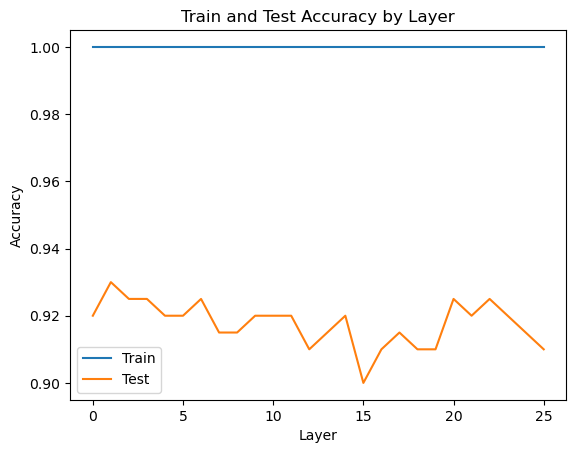

In [11]:


# load models
model1_name = "google/gemma-2-2b"  # Base Gemma-2-2B (LLM)
model2_name = model1_name

gemma = load_models_with_eval(model1_name, DEVICE_1)
paligemma = load_models_with_eval(model2_name, DEVICE_2)

# # Dummy activations (replace with real data)
# gemma_activations = np.random.randn(1000, 768)  # 1000 samples, 768 dims
# gemma_labels = np.random.randint(0, 2, 1000)    # binary cat/dog labels

# polygemma_activations = np.random.randn(200, 768)  # 200 test samples
# polygemma_labels = np.random.randint(0, 2, 200)

layer_to_test = list(range(26))
all_results = []
# Run experiment per layer
for layer in layer_to_test:
    # Produce activation-label pairs
    with torch.inference_mode():
        gemma_activations = get_acts(gemma, cat_texts, layer, model1_name, DEVICE_1)
        polygemma_activations = get_acts(paligemma, cat_texts, layer, model2_name, DEVICE_2)

    # === Run probe experiment ===
    results = experiment.run_experiment(
        gemma_activations, cat_labels,
        polygemma_activations, cat_labels
    )
    all_results.append(results)

    print(f"\n=== LAYER {layer} RESULTS ===")
    print(f"Train Accuracy: {results['sklearn']['train_acc']:.4f}")
    print(f"Test Accuracy: {results['sklearn']['test_acc']:.4f}")
    print("Classification Report:")
    print(results['sklearn']['classification_report'])

    # Save results
    experiment.save_results(results, f"../output/linear_probing_results_{layer}_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.json")

    # Save misclassified examples
    if 'y_test' in results['sklearn'] and 'y_pred' in results['sklearn']:
        mis_indices = [i for i, (yt, yp) in enumerate(zip(
            results['sklearn']['y_test'], results['sklearn']['y_pred']
        )) if yt != yp]
        mis_info = [
            {
                'text': cat_texts[i],  # assuming you meant cat_texts not text
                'true_label': int(results['sklearn']['y_test'][i]),
                'pred_label': int(results['sklearn']['y_pred'][i])
            }
            for i in mis_indices
        ]
        os.makedirs(f"../output/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}", exist_ok=True)
        with open(f"../output/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}/misclassified_layer_{layer}.json", 'w') as f:
            json.dump(mis_info, f, indent=2)
    else:
        print("Warning: 'y_test' or 'y_pred' not found in results; misclassifications not saved.")
          
    del gemma_activations, polygemma_activations, results
    gc.collect()
    torch.cuda.empty_cache()
          
# ===== Plot Train and Test Accuracy Across Layers =====
import matplotlib.pyplot as plt

layers = layer_to_test
train_accs = [res['sklearn']['train_acc'] for res in all_results]
test_accs = [res['sklearn']['test_acc'] for res in all_results]

plt.figure()
plt.plot(layers, train_accs)
plt.plot(layers, test_accs)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Layer')
plt.legend(['Train', 'Test'])
plt.savefig(f"../figs_tabs/Linear Probe Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.png")
plt.show()


# Exp3: PaliGemma-PaliGemma

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 0 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.9300
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       105
           1       0.98      0.87      0.92        95

    accuracy                           0.93       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200

Running linear probing experiment: cat_dog_classification
Gemma trai

Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 9 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.8950
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       105
           1       0.90      0.87      0.89        95

    accuracy                           0.90       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.90      0.89       200

Running linear probing experiment: cat_dog_classification
Gemma trai

Running linear probing experiment: cat_dog_classification
Gemma training data: torch.Size([1000, 64, 2304])
PolyGemma test data: torch.Size([1000, 64, 2304])

--- Training sklearn probe ---
size of gemma_activations_train: torch.Size([800, 64, 2304]), size of gemma_labels_train: 800
size of polygemma_activations_test: torch.Size([200, 64, 2304]), size of polygemma_labels_test: 200
X_train_flat shape: torch.Size([800, 147456])
y_train shape: 800
X_test_flat shape: torch.Size([200, 147456])
y_test shape: 200

=== LAYER 18 RESULTS ===
Train Accuracy: 1.0000
Test Accuracy: 0.9000
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.91       105
           1       0.91      0.87      0.89        95

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200

Running linear probing experiment: cat_dog_classification
Gemma tra

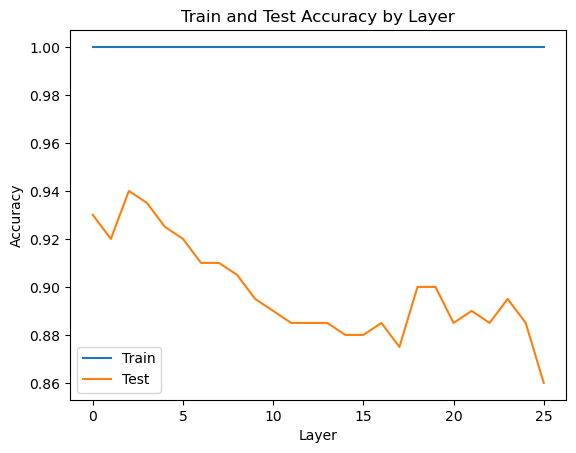

In [10]:


# load models
model2_name = "google/paligemma2-3b-pt-224"
model1_name = model2_name

gemma = load_models_with_eval(model1_name, DEVICE_1)
paligemma = load_models_with_eval(model2_name, DEVICE_2)

# # Dummy activations (replace with real data)
# gemma_activations = np.random.randn(1000, 768)  # 1000 samples, 768 dims
# gemma_labels = np.random.randint(0, 2, 1000)    # binary cat/dog labels

# polygemma_activations = np.random.randn(200, 768)  # 200 test samples
# polygemma_labels = np.random.randint(0, 2, 200)

layer_to_test = list(range(26))
all_results = []
# Run experiment per layer
for layer in layer_to_test:
    # Produce activation-label pairs
    with torch.inference_mode():
        gemma_activations = get_acts(gemma, cat_texts, layer, model1_name, DEVICE_1)
        polygemma_activations = get_acts(paligemma, cat_texts, layer, model2_name, DEVICE_2)

    # === Run probe experiment ===
    results = experiment.run_experiment(
        gemma_activations, cat_labels,
        polygemma_activations, cat_labels
    )
    all_results.append(results)

    print(f"\n=== LAYER {layer} RESULTS ===")
    print(f"Train Accuracy: {results['sklearn']['train_acc']:.4f}")
    print(f"Test Accuracy: {results['sklearn']['test_acc']:.4f}")
    print("Classification Report:")
    print(results['sklearn']['classification_report'])

    # Save results
    experiment.save_results(results, f"../output/linear_probing_results_{layer}_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.json")

    # Save misclassified examples
    if 'y_test' in results['sklearn'] and 'y_pred' in results['sklearn']:
        mis_indices = [i for i, (yt, yp) in enumerate(zip(
            results['sklearn']['y_test'], results['sklearn']['y_pred']
        )) if yt != yp]
        mis_info = [
            {
                'text': cat_texts[i],  # assuming you meant cat_texts not text
                'true_label': int(results['sklearn']['y_test'][i]),
                'pred_label': int(results['sklearn']['y_pred'][i])
            }
            for i in mis_indices
        ]
        os.makedirs(f"../output/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}", exist_ok=True)
        with open(f"../output/{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}/misclassified_layer_{layer}.json", 'w') as f:
            json.dump(mis_info, f, indent=2)
    else:
        print("Warning: 'y_test' or 'y_pred' not found in results; misclassifications not saved.")
          
    del gemma_activations, polygemma_activations, results
    gc.collect()
    torch.cuda.empty_cache()
          
# ===== Plot Train and Test Accuracy Across Layers =====
import matplotlib.pyplot as plt

layers = layer_to_test
train_accs = [res['sklearn']['train_acc'] for res in all_results]
test_accs = [res['sklearn']['test_acc'] for res in all_results]

plt.figure()
plt.plot(layers, train_accs)
plt.plot(layers, test_accs)
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy by Layer')
plt.legend(['Train', 'Test'])
plt.savefig(f"../figs_tabs/Linear Probe Train and Test Accuracy by Layer_{model1_name.split('/')[-1]}_{model2_name.split('/')[-1]}.png")
plt.show()
